In [1]:
# Running on Colab
!pip install andi-datasets==0.0.5
!pip install fbm==0.3.0
!git clone --depth 1 https://github.com/tsmbland/andi_challenge.git
import sys
sys.path.append('andi_challenge')
from andi_funcs import package_tracks
import andi
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, f1_score
np.random.seed(3) 

# # Running locally
# import andi
# import matplotlib.pyplot as plt
# import numpy as np
# import sys
# sys.path.append('..')
# from andi_funcs import package_tracks
# from tensorflow.keras.models import load_model
# from sklearn.metrics import confusion_matrix, f1_score
# %matplotlib notebook
# np.random.seed(3) 

## Inference of diffusion model using trained CNNs

This notebook demonstrates how to use the trained CNN models in this package to perform model classification on trajectories. This is demonstrated here with simulated (1D) data.

First we need to load the relevant model for 1D tracks. There is a separate model for 2D tracks.

#### Load model

In [2]:
model = load_model('andi_challenge/Task2_Classification/Models/1D.h5');

2023-01-18 09:22:11.673304: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Generate data

Generate data using the andi_datasets package. This will simulate a series of tracks, each track based on one of five possible models:

0. attm
1. ctrw
2. fbm
3. lw
4. sbm

classes_truth represents the model of each trajectory according to the above list. See the andi_datasets package for more details.

In [3]:
AD = andi.andi_datasets()
X1, Y1, X2, Y2, X3, Y3 = AD.andi_dataset(N=100, min_T=10, max_T=1001, tasks=[2], dimensions=[1])

classes_truth = np.array(Y2[0]).astype(int)
tracks = X2[0]

Creating a dataset for task(s) [2] and dimension(s) [1].
Generating dataset for dimension 1.


/Users/blandt/anaconda3/anaconda3/envs/andi_challenge/lib/python3.7/site-packages/andi/diffusion_models.py:65: RuntimeWarning: invalid value encountered in reciprocal
  times = np.cumsum((1-np.random.rand(T))**(-1/alpha))
/Users/blandt/anaconda3/anaconda3/envs/andi_challenge/lib/python3.7/site-packages/fbm/fbm.py:172: UserWarning: Combination of increments n and Hurst value H invalid for Davies-Harte method. Reverting to Hosking method. Occurs when n is small and Hurst is close to 1. 
  "Combination of increments n and Hurst value H "


#### Preprocess/package tracks

Preprocessing and packaging the tracks for input into the CNN. See [here](trajectory_preprocessing.ipynb) for details.

In [4]:
cnn_input = package_tracks(tracks=tracks, max_T=1001, dimensions=1)

#### Perform predictions

The CNN model takes the cnn_input and outputs 5 numbers for each trajectory, representing a probability for each of the five models

In [5]:
cnn_output = model.predict(cnn_input)
print(cnn_output.shape)

4/4 [==============================] - 2s 214ms/step
(100, 5)


We can convert this to class predictions by finding the highest scoring model for each trajectory

In [6]:
classes_predicted = np.argmax(cnn_output, axis=1)

#### Assessing the quality of predictions

It looks like the CNN is predicting the correct diffusion model most of the time (high values along the diagonal of the confusion matrix and a high F1 score). 

In [7]:
conf = confusion_matrix(classes_truth, classes_predicted, normalize='true')

<IPython.core.display.Javascript object>


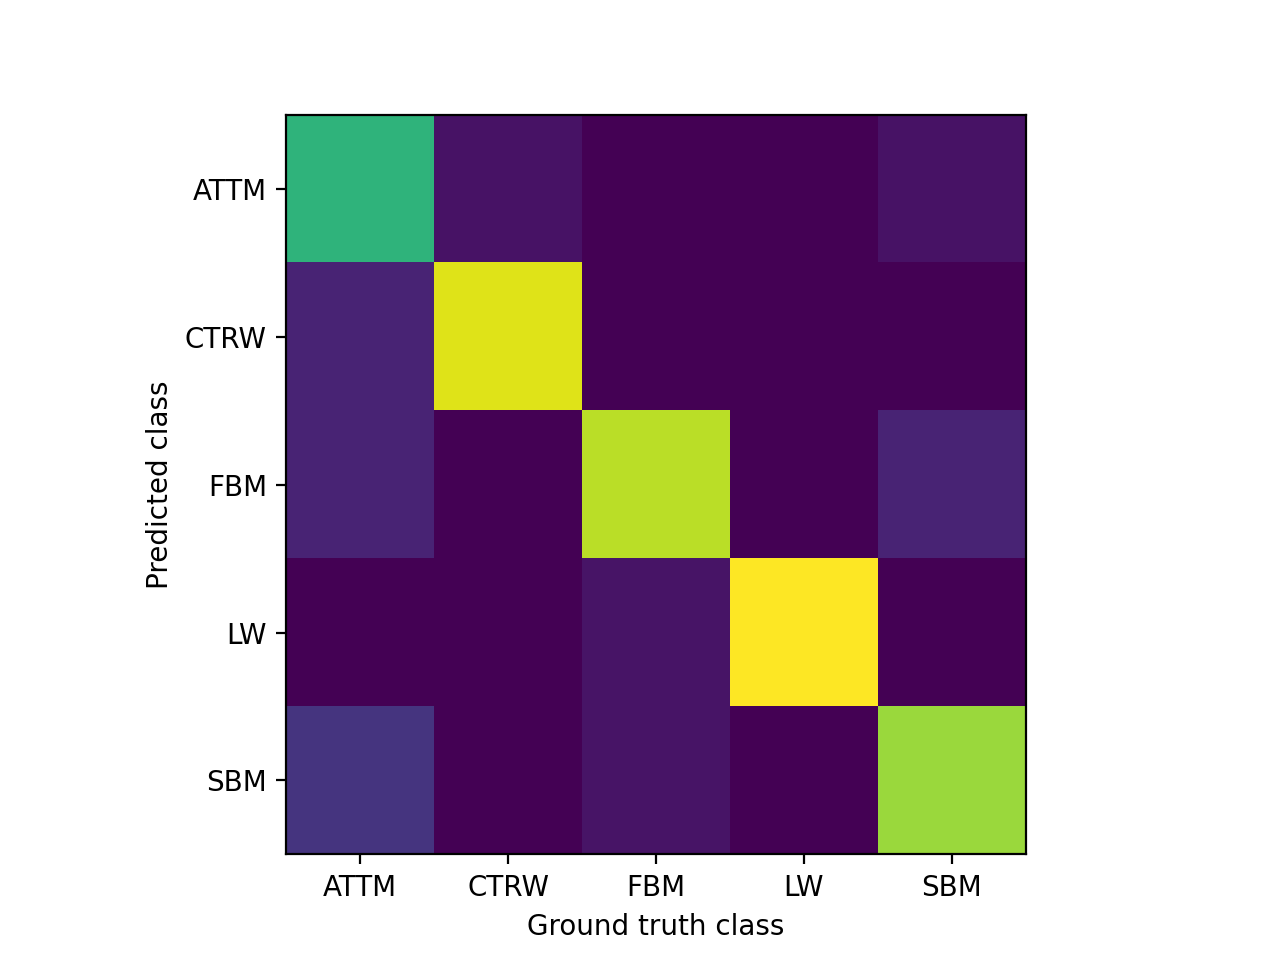

/Users/blandt/anaconda3/anaconda3/envs/andi_challenge/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/blandt/anaconda3/anaconda3/envs/andi_challenge/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  after removing the cwd from sys.path.


In [8]:
fig, ax = plt.subplots()
ax.imshow(conf.T)
ax.set_xticklabels(['ATTM','CTRW','FBM', 'LW', 'SBM'])
ax.set_yticklabels(['ATTM','CTRW','FBM', 'LW', 'SBM'])
ax.set_xticks([0, 1, 2, 3, 4])
ax.set_yticks([0, 1, 2, 3, 4])
ax.set_ylabel('Predicted class')
ax.set_xlabel('Ground truth class');

In [9]:
f1 = f1_score(classes_truth, classes_predicted, average='micro')
print('F1 score:', f1)

F1 score: 0.87
